In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Data Exploration

In [2]:
url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)

In [3]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,50886,51039,51280,51350,51405,51526,51526,51526,51526,53011
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,55755,56254,56572,57146,57727,58316,58316,58991,59438,59623
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,97857,98249,98631,98988,99311,99610,99897,100159,100408,100645
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,7806,7821,7875,7919,7983,8049,8117,8166,8192,8249
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,17149,17240,17296,17371,17433,17553,17568,17608,17642,17684


In [4]:
df = df.iloc[:,4:]
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21
0,0,0,0,0,0,0,0,0,0,0,...,50886,51039,51280,51350,51405,51526,51526,51526,51526,53011
1,0,0,0,0,0,0,0,0,0,0,...,55755,56254,56572,57146,57727,58316,58316,58991,59438,59623
2,0,0,0,0,0,0,0,0,0,0,...,97857,98249,98631,98988,99311,99610,99897,100159,100408,100645
3,0,0,0,0,0,0,0,0,0,0,...,7806,7821,7875,7919,7983,8049,8117,8166,8192,8249
4,0,0,0,0,0,0,0,0,0,0,...,17149,17240,17296,17371,17433,17553,17568,17608,17642,17684


In [5]:
df.isnull().sum()

1/22/20     0
1/23/20     0
1/24/20     0
1/25/20     0
1/26/20     0
           ..
12/31/20    0
1/1/21      0
1/2/21      0
1/3/21      0
1/4/21      0
Length: 349, dtype: int64

In [6]:
daily_cases = df.sum(axis=0)
daily_cases.head()

1/22/20     555
1/23/20     654
1/24/20     941
1/25/20    1434
1/26/20    2118
dtype: int64

In [7]:
daily_cases.index = pd.to_datetime(daily_cases.index)

In [8]:
daily_cases.head()

2020-01-22     555
2020-01-23     654
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

Text(0.5, 1.0, 'Total Daily Cases')

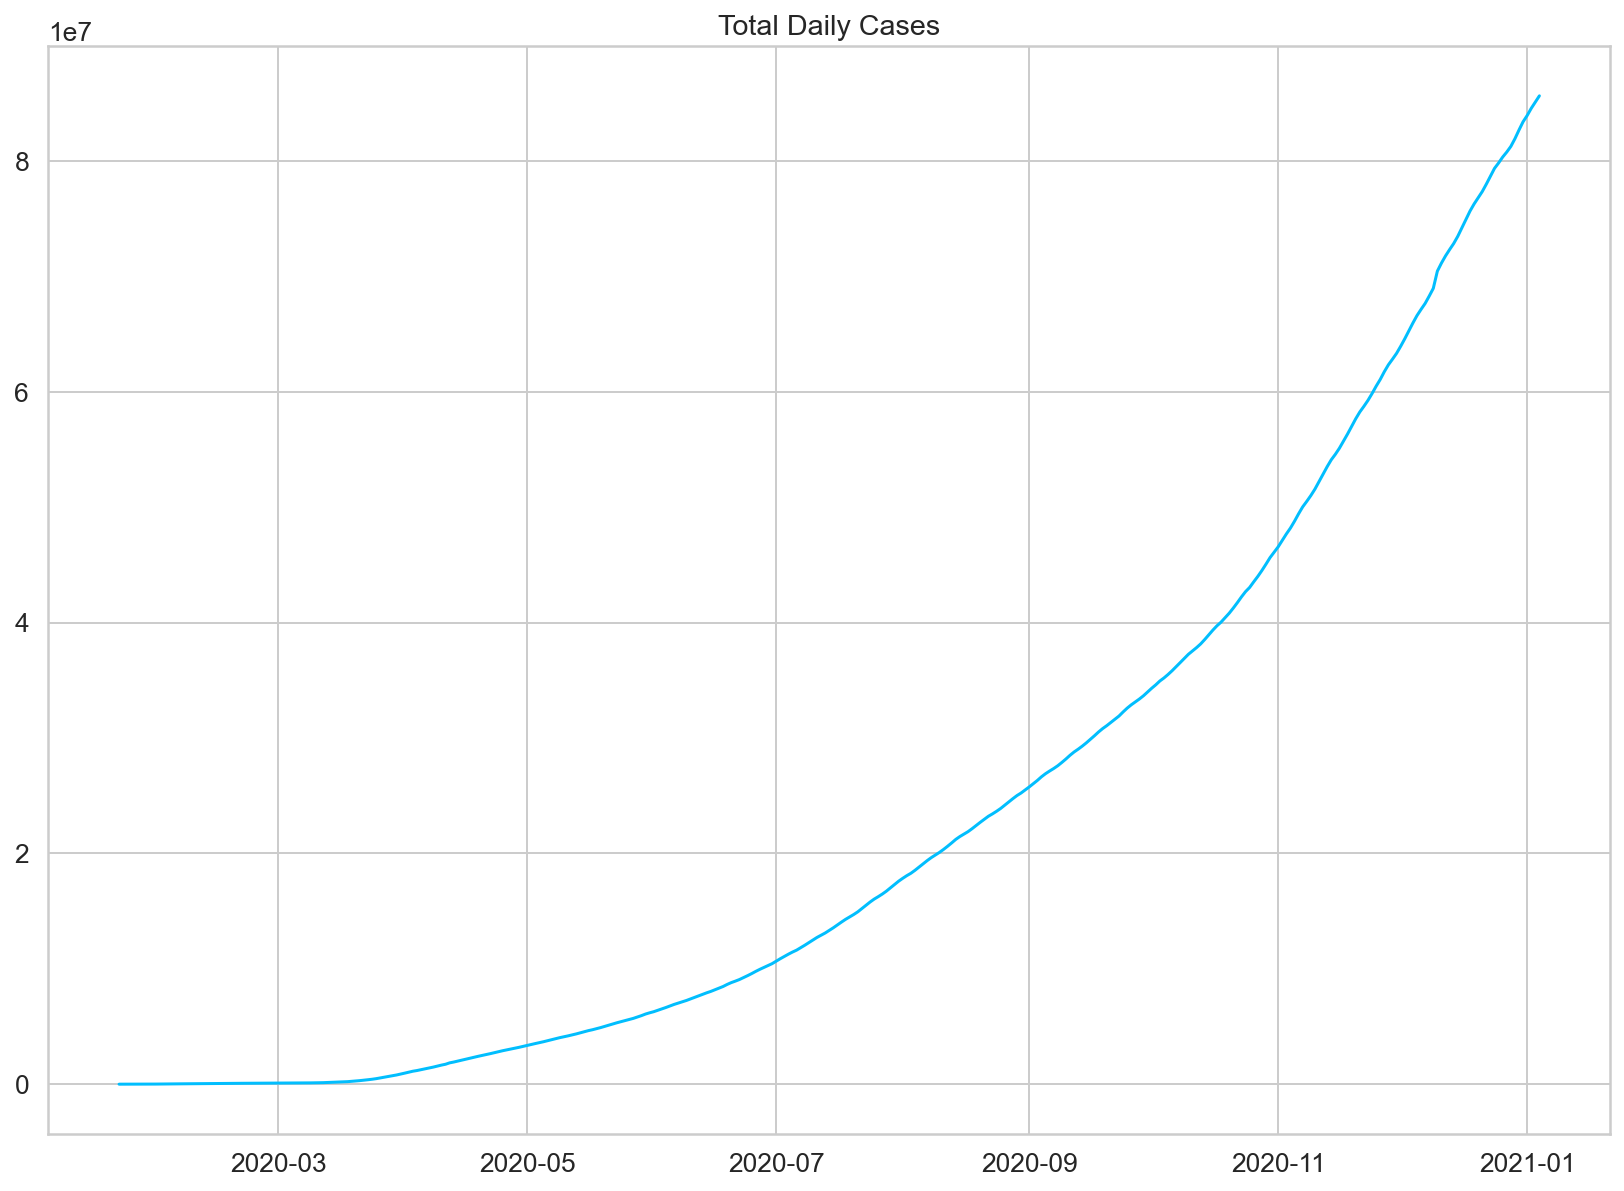

In [9]:
plt.plot(daily_cases)
plt.title('Total Daily Cases')

In [10]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)

In [11]:
daily_cases.head()

2020-01-22    555
2020-01-23     99
2020-01-24    287
2020-01-25    493
2020-01-26    684
dtype: int64

Text(0.5, 1.0, 'Total Daily Cases')

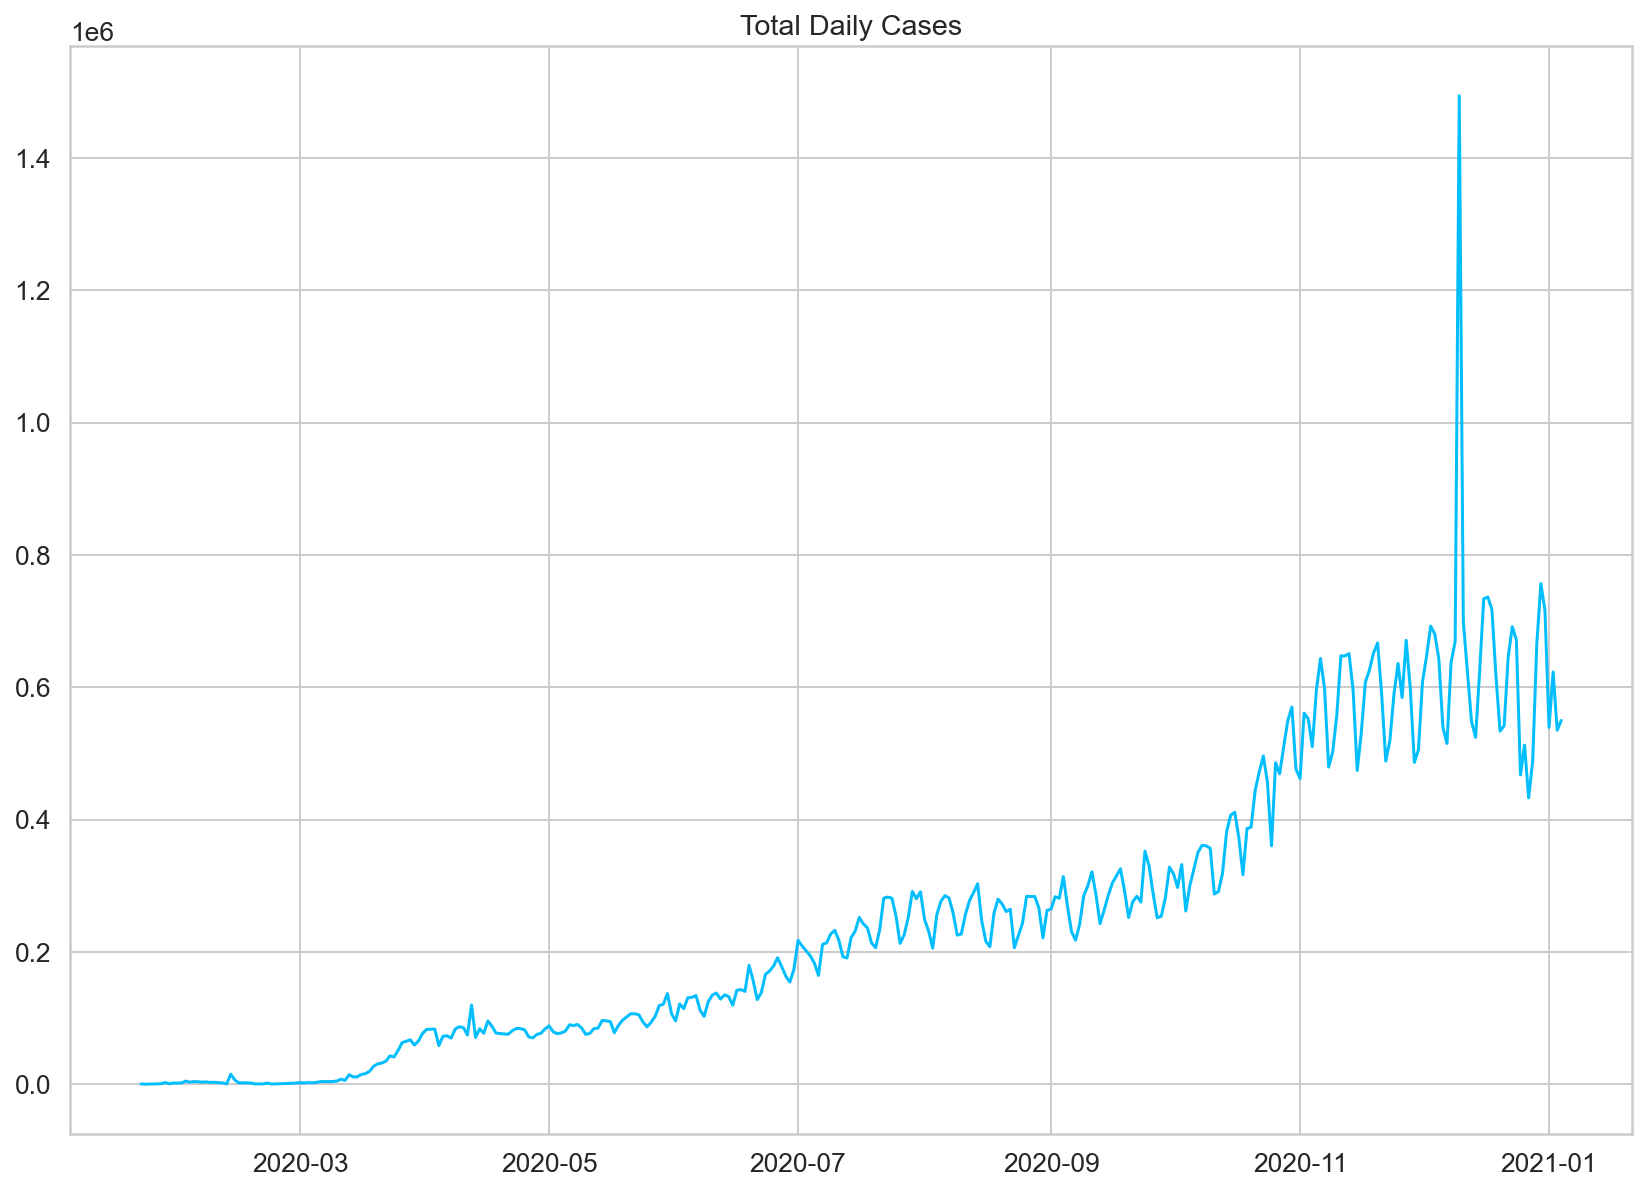

In [12]:
plt.plot(daily_cases)
plt.title('Total Daily Cases')

In [13]:
daily_cases.shape

(349,)

## Preprocessing

In [14]:
test_data_size = 115
train_data = daily_cases[: -test_data_size]
test_data = daily_cases[-test_data_size:]

In [15]:
train_data.shape

(234,)

In [16]:
test_data.shape

(115,)

In [17]:
scaler = MinMaxScaler()
scaler_one = scaler.fit(np.expand_dims(train_data , axis=1))

train_data = scaler.transform(np.expand_dims(train_data , axis=1))
test_data =  scaler.transform(np.expand_dims(test_data , axis=1))

In [18]:
def sliding_window(data , seq_length):
    xs = []
    ys = []
    
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs) , np.array(ys)    

In [19]:
seq_length = 5

X_train , y_train = sliding_window(train_data,seq_length)
X_test , y_test = sliding_window(test_data,seq_length)

In [20]:
X_train.shape

(228, 5, 1)

In [21]:
y_train.shape

(228, 1)

In [22]:
X_train[:2]

array([[[0.00142061],
        [0.        ],
        [0.00058569],
        [0.00122746],
        [0.0018225 ]],

       [[0.        ],
        [0.00058569],
        [0.00122746],
        [0.0018225 ],
        [0.00221192]]])

In [23]:
y_train[:2]

array([[0.00221192],
       [0.00795045]])

In [24]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [25]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(349, 1)

In [26]:
X_all, y_all = sliding_window(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

## Model

In [27]:
class covid(nn.Module):
    def __init__(self , input_dim , hidden_dim , seq_len , num_layers=2):
        super(covid , self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_dim,hidden_size = hidden_dim, num_layers = num_layers , dropout =0.5)
        
        self.linear = nn.Linear(in_features=hidden_dim , out_features=1)
        
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.num_layers , self.seq_len, self.hidden_dim),
            torch.zeros(self.num_layers , self.seq_len , self.hidden_dim),
        )
    
    def forward(self,input):
        lstm_out,_ = self.lstm(
            input.view(len(input) , self.seq_len , -1),
            self.hidden
        )
        y_pred = self.linear(
            lstm_out.view(self.seq_len , len(input) , self.hidden_dim)[-1 ]
        )
         
        return y_pred

In [28]:
def train_model(model , train_data, train_labels , test_data=None , test_labels=None):
    loss_fn = nn.MSELoss(reduction='sum')
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    num_epochs = 100
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(),y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(),y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:  
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
            elif t % 10 == 0:
                print(f'Epoch {t} train loss: {loss.item()}')

            train_hist[t] = loss.item()
    
            optimiser.zero_grad()

            loss.backward()

            optimiser.step()
  
    return model.eval(), train_hist, test_hist

In [29]:
model = covid(1 , 512 , seq_len = seq_length , num_layers=2)
model,train_hist, test_hist = train_model(model,X_all,y_all)

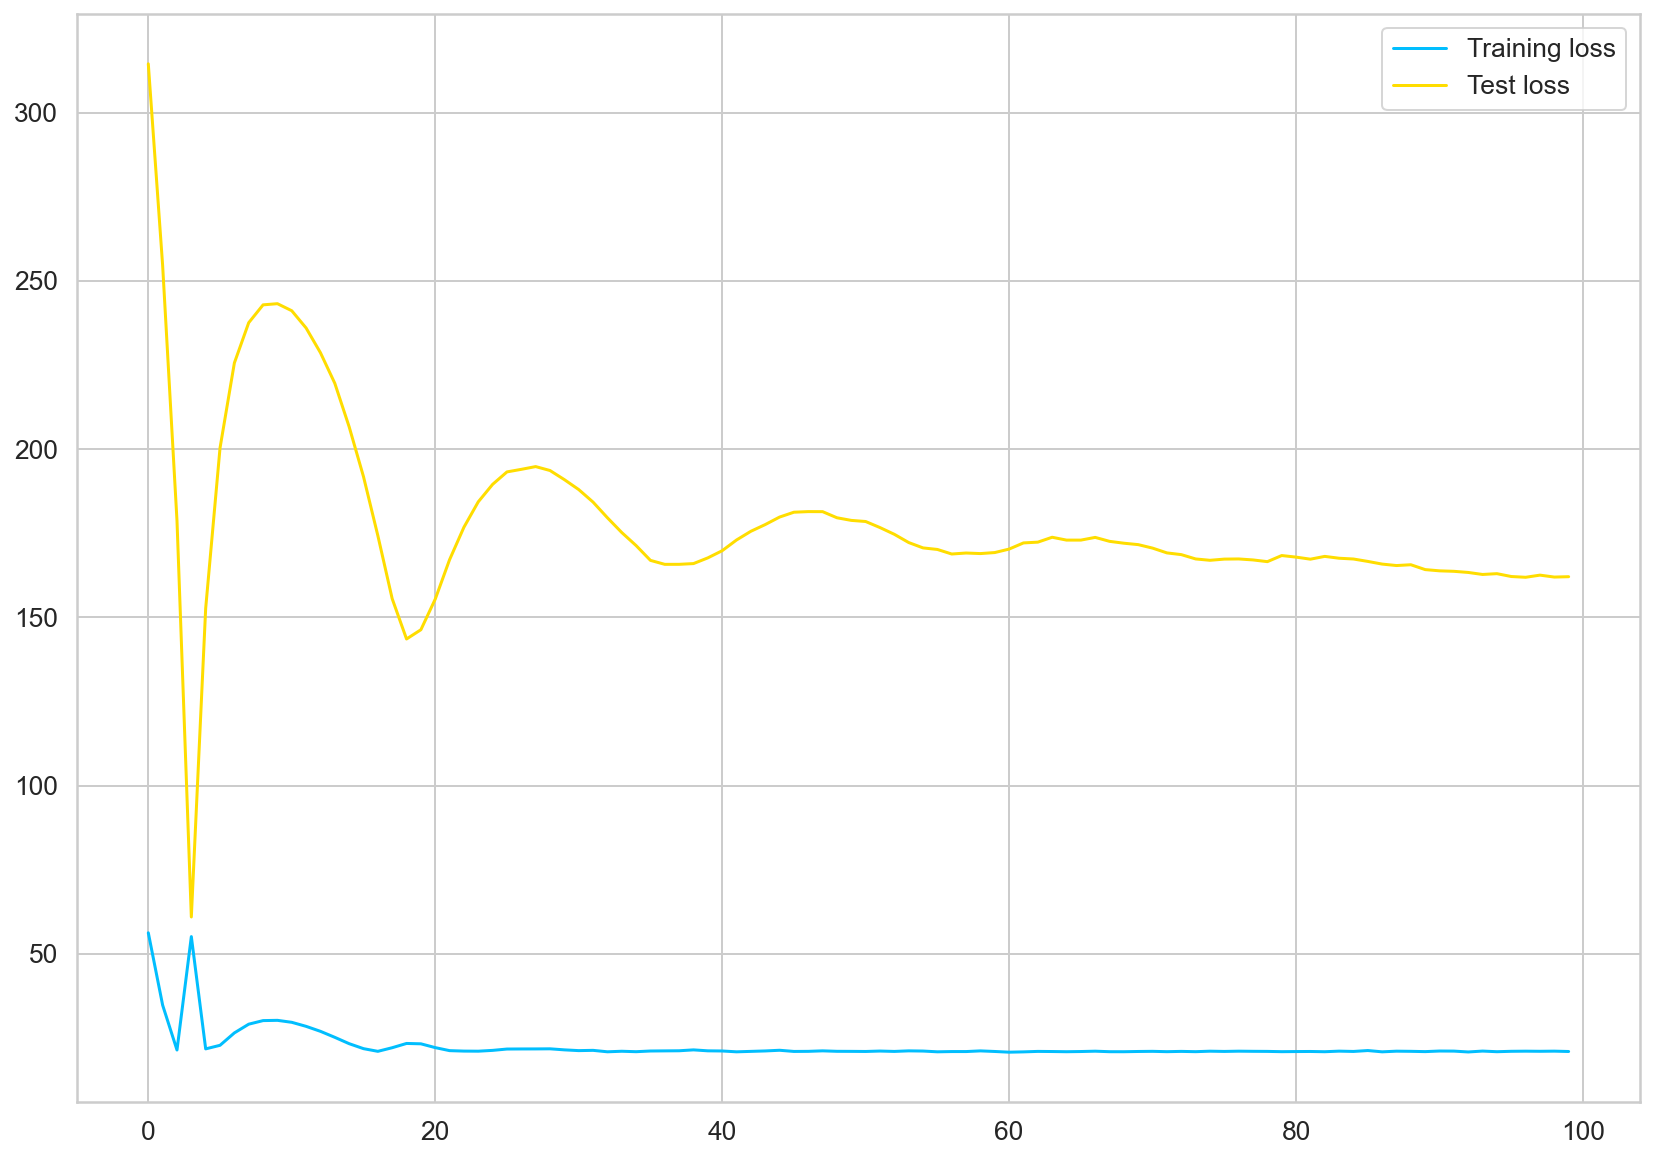

In [129]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")

plt.legend();

In [130]:
with torch.no_grad():
    test_seq = X_test[:1]
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [131]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

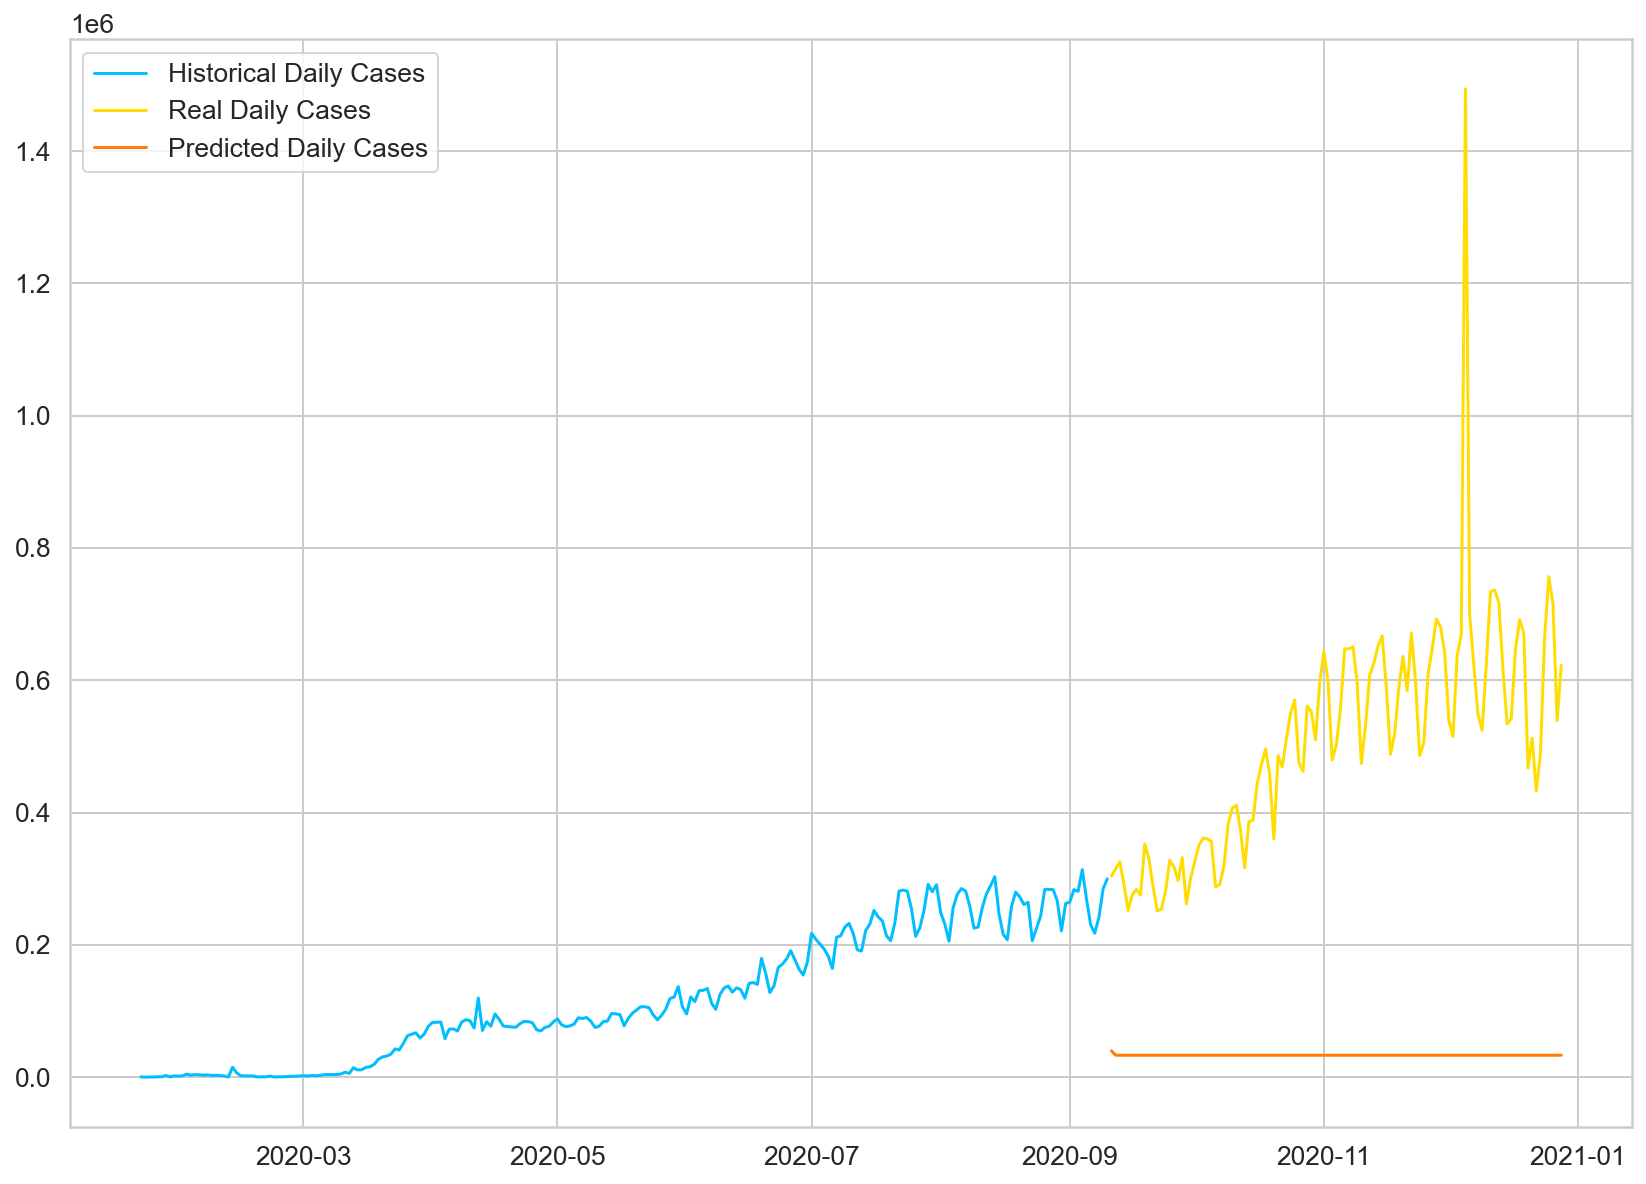

In [132]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

In [133]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(348, 1)

In [145]:
X_all, y_all = sliding_window(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

#model = covid(1, 512, seq_len=seq_length, num_layers=2)
#model, train_hist, _ = train_model(model, X_all, y_all)

model = covid(1 , 512 , seq_len = seq_length , num_layers=2)
model,train_hist , _ = train_model(model,X_all,y_all)

In [139]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [140]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()



In [141]:
daily_cases.index[-1]

Timestamp('2021-01-03 00:00:00')

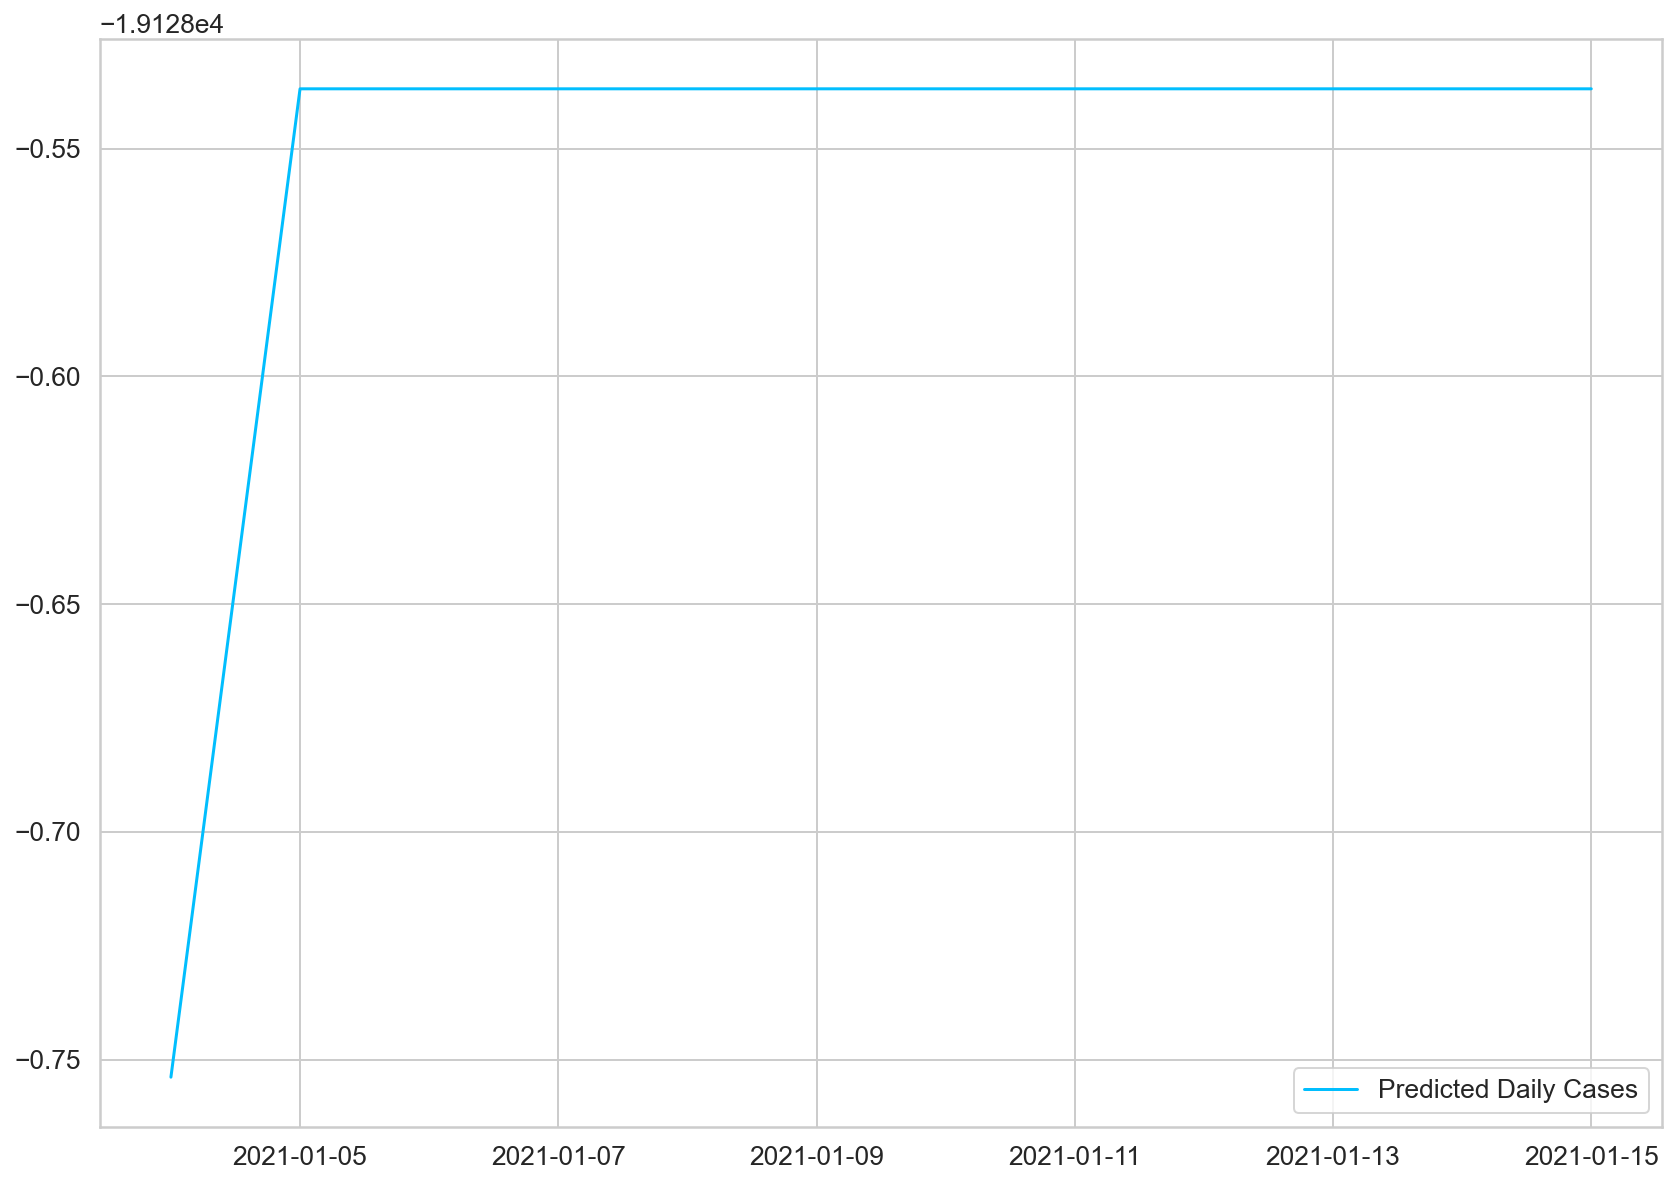

In [142]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

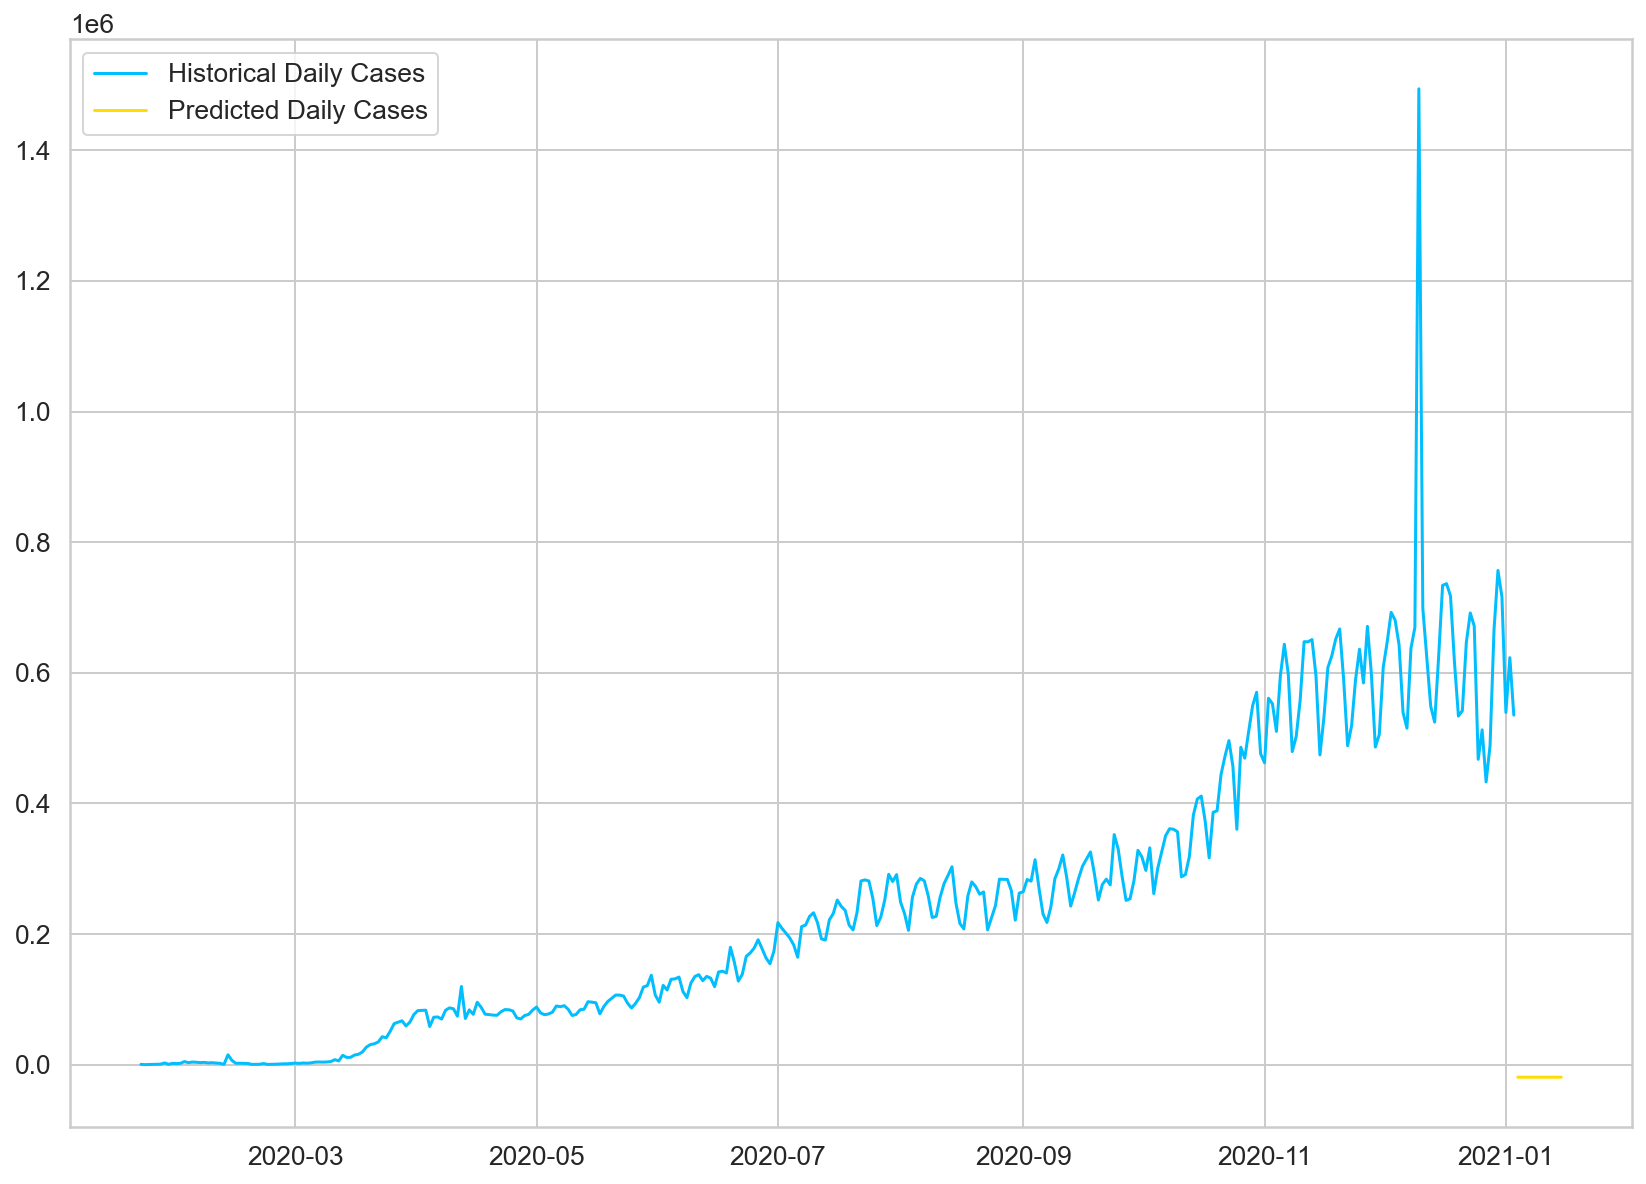

In [143]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

